# Sentiment Evaluation Of Customer Feedback Using NLP

##### Name      : Christy Sara Saji
##### Student ID: GH1033765
##### Module    : M508E Big Data Analytics (SS0325)

## Table Of content
1. Introduction 
2. Problem Statement   
3. Methodology

   3.1. Data Collection  
   3.2. Data Cleaning and Preprocessing  
   3.3. Exploratory Data Analysis (EDA)   
4. Modeling
   
   4.1. Feature Engineering (TF-IDF, Tokenization)  
   4.2. SVM Model Training and Validation (along with class balancing)
   4.3. BERT Model Fine-Tuning and Validation (along with class balancing)

5. Evaluation  
   5.1. Evaluation Metrics  
   5.2. Comparison of Models(SVM vs. BERT)  
    

6. Final Discussion on the Overall Pipeline  

7. References  


##### Since the dataset exceeds more than 25MB, I was not able to upload the link to GitHub. Therefore, I am attaching the link to the Jupyter notebook, where I implemented the pipeline: 
##### http://localhost:8889/files/GH1033765NLP.ipynb?_xsrf=2%7C1fac6178%7C6e3b0cd02543bb0f302987d3e88731cd%7C1749663471

# 1. Introduction

### The Overview of Business Problem
#### In this digital era, firms receive a lot of feedback from customers through reviews and other social media. It is essential for them to understand customer preferences and public concerns, which helps the companies to improve their products and services accordingly for better growth.

## The Objective of Business Problem
#### The aim of this project is to create an end-to-end multi-class Natural Language Processing (NLP) pipeline that categorizes customer feedback as positive, negative, or neutral; which helps organizations detect the feedback of customers and resolve the issues

# 2. Business Problem
#### Analysing customer feedback manually takes longer than expected, and it may also not produce accurate results. However, the automated sentiment analysis using NLP can provide error-free results quickly; which reduces the cost of working and also enhances decision making.

## Significance of solving Business Problem
#### * Customer issues can be identified and resolved, which provides better insights into customer satisfaction.
#### * According to the feedback obtained through data-driven strategies, the products and services can be improved.

# 3. Methodology

## Dataset Overview
#### Dataset link: https://www.kaggle.com/datasets/simaanjali/emotion-analysis-based-on-text/data

## Architecture of NLP pipeline
#### 1. Data Accumulation
##### Collected the customer feedback data, which is stored in a CSV file.
#### 2. Preprocesses the Text
##### Text Preprocessing is done using different techniques such as cleaning, tokenization, lowercasing, stopword removal, and lemmatization.
#### 3. Feature Extraction
##### * TF-IDF Extraction: The cleaned text will be changed into numerical feature vectors, which needs to be done for SVM model
##### * BERT Input Preparation: The preprocessed text is directly proceed to the BERT model using the Hugging Face Transformers API, which operates tokenization and formatting internally.
#### 4. Model Training
##### Trained and tuned on SVM Model and BERT Model
#### 5. Model Evaluation
##### Based on Accuracy, F1-score, and confusion matrices, model evaluation is done.
#### 6. Interpretation and insights
##### Analysis and discussion of Model explainability, strengths, limitations, and further recommendations.

# The Pipeline Flowchart of NLP model

    +----------------------+
    |   Data Collection    |
    +----------------------+
              |
              v
    +---------------------------+
    |   Text Preprocessing      |
    +---------------------------+
              |
              v
    +-------------------+    +---------------------+
    | TF-IDF Vectorizer |    |   BERT Tokenizer    |
    +-------------------+    +---------------------+
              |                     |
              v                     v
    +-------------------+    +---------------------+
    |   SVM Training    |    | BERT Fine-tuning    |
    +-------------------+    +---------------------+
              |                     |
              v                     v
    +-------------------+    +---------------------+
    |  SVM Evaluation   |    |  BERT Evaluation    |
    +-------------------+    +---------------------+
              |                     |
              +----------+----------+
                         |
                         v
    +-------------------------------------------------------------+
    | Model Comparison, Visualization, and Business Recommendations |
    +-------------------------------------------------------------+


# Load the Data for preprocessing

In [33]:
# importing the necessary libraries which is useful for classical models and BERT implementation
import pandas as pd
import numpy as np
import re
import string

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,f1_score,log_loss
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight

from wordcloud import WordCloud
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.optim import AdamW

# download nltk data
nltk.download('stopwords')
nltk.download('wordnet')

import os
os.environ["HF_HUB_DISABLE_SYMLINKS_WARNING"] = "1"  #ignore the unnecessary warnings obtained in BERT tokenisation

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\chris\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\chris\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [34]:
# load the dataset
df = pd.read_csv('emotion_sentimen_dataset.csv')
df.head()  # display the first few rows of the dataset

,Unnamed: 0,text,Emotion
0,0,i seriously hate one subject to death but now ...,hate
1,1,im so full of life i feel appalled,neutral
2,2,i sit here to write i start to dig out my feel...,neutral
3,3,ive been really angry with r and i feel like a...,anger
4,4,i feel suspicious if there is no one outside l...,neutral


In [35]:
# provides overview of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 839555 entries, 0 to 839554
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  839555 non-null  int64 
 1   text        839555 non-null  object
 2   Emotion     839555 non-null  object
dtypes: int64(1), object(2)
memory usage: 19.2+ MB


In [36]:
# mapping dictionary is described for transforming values
emotion_to_sentiment = {
    'joy': 'positive',
    'love': 'positive',
    'surprise': 'positive',
    'happy': 'positive',
    'anger': 'negative',
    'hate': 'negative',
    'sadness': 'negative',
    'fear': 'negative',
    'disgust': 'negative',
    'neutral': 'neutral'
}

# implement mapping
df['Sentiment'] = df['Emotion'].map(emotion_to_sentiment)

# drop the rows where maping could not suceed, example: unknown emotion
df = df.dropna(subset=['Sentiment'])

# prints the distribution
print(df['Sentiment'].value_counts())


Sentiment
neutral     674538
positive     46507
negative     45084
Name: count, dtype: int64


#### Mapping is done from emotions to sentiment classes in the above, the result shows that the dataset consist of three sentiment classes, which are positive, neutral and negative. However, the neutral comments are much more than the positive and negative, resulting in class imbalance

In [37]:
df = df[['text', 'Sentiment']].copy()
df = df.dropna().drop_duplicates()
df['text'] = df['text'].str.strip()
df['Sentiment'] = df['Sentiment'].str.strip().str.lower()
df = df.reset_index(drop=True)

#### Initial data cleaning is done in the above cell before further text preprocessing.

In [38]:
#overview of the cleaned dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 358596 entries, 0 to 358595
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   text       358596 non-null  object
 1   Sentiment  358596 non-null  object
dtypes: object(2)
memory usage: 5.5+ MB


In [39]:
df = df.reset_index(drop=True)

print("Dataset has been cleaned now.")
print(f"Dataset shape: {df.shape}")

Dataset has been cleaned now.
Dataset shape: (358596, 2)


# Exploratory Data Analysis (EDA)

In [40]:
# analysing and distributing sentiment values 
print("\nSentiment allocation:")
sentiment_counts = df['Sentiment'].value_counts()
print(sentiment_counts)
print("\nPercentage allocation:")
print(df['Sentiment'].value_counts(normalize=True).round(3) * 100)


Sentiment allocation:
Sentiment
neutral     316935
positive     21064
negative     20597
Name: count, dtype: int64

Percentage allocation:
Sentiment
neutral     88.4
positive     5.9
negative     5.7
Name: proportion, dtype: float64


#### Sentiment labels are distributed in the above cell

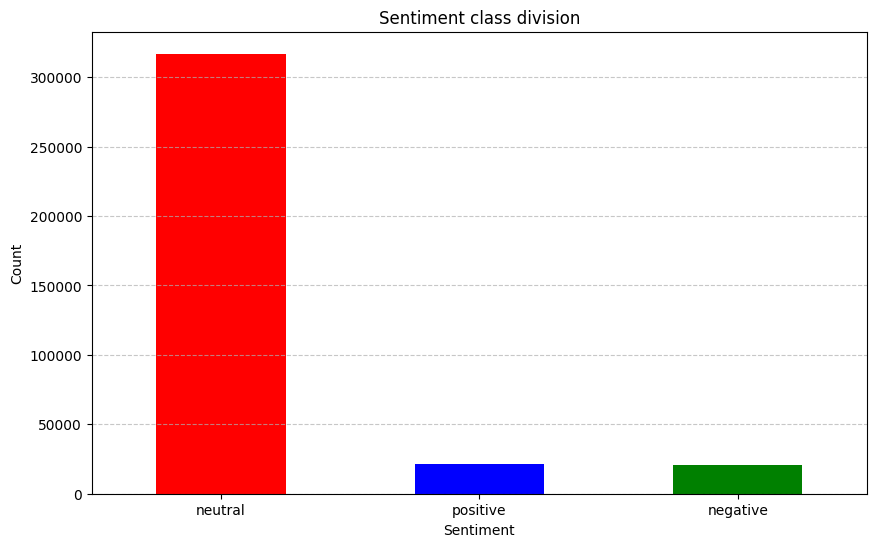

In [41]:
# bar chart of Sentiment class
plt.figure(figsize=(10, 6))
sentiment_counts.plot(kind='bar', color=['red', 'blue', 'green'])
plt.title('Sentiment class division')
plt.ylabel('Count')
plt.xlabel('Sentiment')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

([<matplotlib.patches.Wedge at 0x22e40928190>,
 [Text(-1.0275423209741474, 0.39262804103510274, 'neutral'),
  Text(0.9403943072837777, -0.5706650040332455, 'positive'),
  Text(1.0821400288710095, -0.19741569824877347, 'negative')])

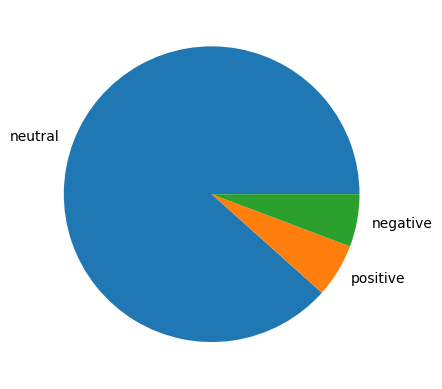

In [42]:
# pie chart of Sentiment class
plt.pie(df.Sentiment.value_counts(), labels = df.Sentiment.value_counts().index)

#### Analysing class distribution shows that the dataset is highly imbalanced, indicating neutral category comprises the most of the samples in the dataset. Due to the high imbalance in classes, the model may be biased and predict the majority class.

In [43]:
# Analysing the text length in the dataset
df['text_length'] = df['text'].str.split().str.len()
print("\nText length statistics:")
print(df['text_length'].describe().round(2))


Text length statistics:
count    358596.00
mean         18.88
std          10.91
min           1.00
25%          10.00
50%          17.00
75%          25.00
max         178.00
Name: text_length, dtype: float64


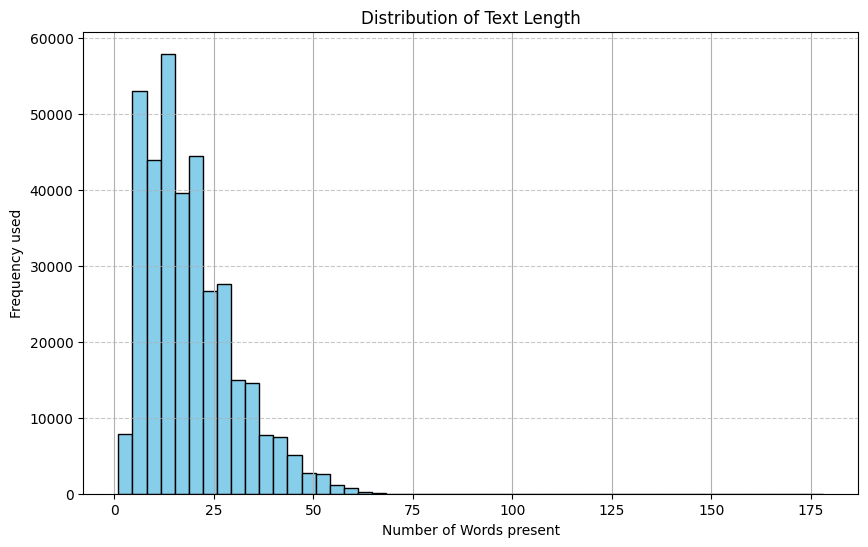

In [44]:
# visualises text length distribution using histogram
plt.figure(figsize=(10, 6))
df['text_length'].hist(bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Text Length')
plt.xlabel('Number of Words present')
plt.ylabel('Frequency used')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

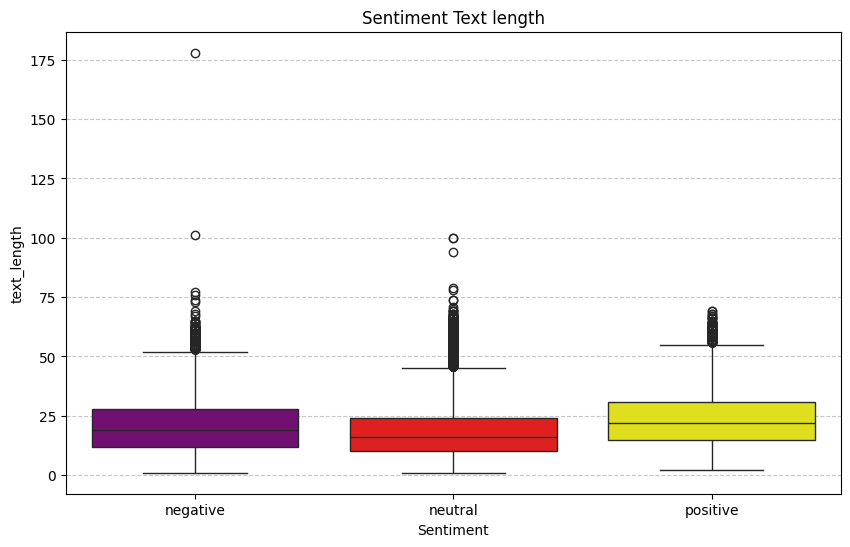

In [45]:
# visualises the distribution of text lengths for each sentiment class
plt.figure(figsize=(10, 6))
sns.boxplot(x='Sentiment', y='text_length', data=df, hue='Sentiment', palette=['purple', 'red', 'yellow'], legend=False)
plt.title('Sentiment Text length')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


#### The figure states that positive sentiment texts become more longer than negative and neutral. Even though the dataset is not so balanced, and the neutral class is the most frequent, it is visible here that users convey positive emotions more in detail than the neutral emotions. Therefore, It may impact the model's behavior as the model might learn to follow longer texts along with positive sentiment.

In [46]:
# display sample texts of each sentiment class
print("\nSome sample texts are given from each sentiment class:")
for sentiment in df['Sentiment'].unique():
    print(f"\n{sentiment.upper()} example:")
    print(df[df['Sentiment'] == sentiment]['text'].iloc[0])


Some sample texts are given from each sentiment class:

NEGATIVE example:
i seriously hate one subject to death but now i feel reluctant to drop it

NEUTRAL example:
im so full of life i feel appalled

POSITIVE example:
i feel jealous becasue i wanted that kind of love the true connection between two souls and i wanted that


#### The above examples shows that the positive texts are more expressive, neutral texts are short, and negative texts express only negative emotions.

In [47]:
# finds the most unique and common words from each class
for sentiment in df['Sentiment'].unique():
    words = ' '.join(df[df['Sentiment'] == sentiment]['text']).split()
    common_words = Counter(words).most_common(10)
    print(f"\nUsual words present in {sentiment} sentiment:")
    for word, count in common_words:
        print(f"{word}: {count}")



Usual words present in negative sentiment:
i: 37021
and: 15826
feel: 13500
to: 11908
the: 11027
feeling: 8288
a: 7649
that: 7272
of: 6921
my: 5440

Usual words present in neutral sentiment:
i: 499756
feel: 220197
and: 173667
to: 169316
the: 156692
a: 122417
feeling: 100493
that: 94608
of: 93936
my: 79799

Usual words present in positive sentiment:
i: 40152
and: 18214
feel: 15182
the: 14650
to: 14113
love: 11254
a: 9319
that: 8876
of: 8626
my: 7637


#### The above examples shows that some words such as 'i','my','feel','and' are present in all the three classes, showcasing the personal and emotional state of the texts. Thus, the overlap describes that the model cannot use just keywords, instead it has to focus on the context and combination of words to distinguish sentiment.

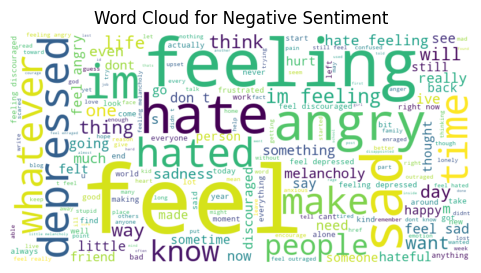

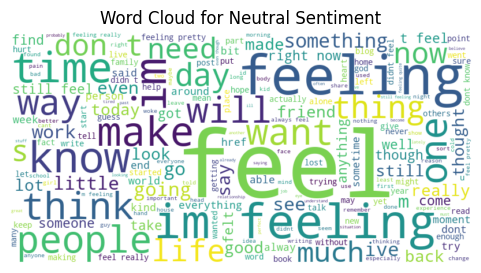

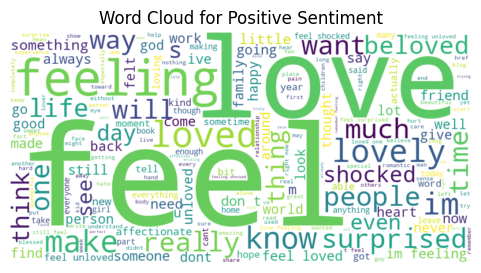

In [48]:
# creating word clouds for all the three sentiment class seperately
for sentiment in df['Sentiment'].unique():
    text = ' '.join(df[df['Sentiment'] == sentiment]['text'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(6, 3))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for {sentiment.capitalize()} Sentiment')
    plt.show()


#### Word cloud is a visualising tool for identifying different vocabulories present in the sentiment class. From the above figure, it is clear that the most common word in all the three classes is 'feel', which is associated with the emotions.

## Splitting the data

In [49]:
# data is split into training and test for analysis
X = df['text']
y = df['Sentiment']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training data size: {len(X_train)}")
print(f"Test data size: {len(X_test)}")
print("\nTraining data:")
print(y_train.value_counts(normalize=True).round(3) * 100)
print("\nTest data:")
print(y_test.value_counts(normalize=True).round(3) * 100)
labels = sorted(y_test.unique())

Training data size: 286876
Test data size: 71720

Training data:
Sentiment
neutral     88.4
positive     5.9
negative     5.7
Name: proportion, dtype: float64

Test data:
Sentiment
neutral     88.4
positive     5.9
negative     5.7
Name: proportion, dtype: float64


# Text preprocessing

In [50]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess(text):
    # change text to lowercase
    text = text.lower()
    
    # delete the URLs
    text = re.sub(r'http\S+|www\S+', '', text)
    
    # delete the HTML tags
    text = re.sub(r'<.*?>', '', text)
    
    # Remove the punctuations present
    text = re.sub(r'[^\w\s]', '', text)
    
    # eliminate the numbers
    text = re.sub(r'\d+', '', text)
    
    # eliminate the extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Tokenize the text
    tokens = text.split()
    
    # remove the stopwords and lemmatize
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    
    return ' '.join(tokens)

X_train_clean = X_train.apply(preprocess)
X_test_clean = X_test.apply(preprocess)

# display 3 set of samples
for i in range(3):
    print(f"\nSample {i+1}:")
    print("Original text:")
    print(X_train.iloc[i])
    print("\nProcessed text:")
    print(X_train_clean.iloc[i])
    print("-" * 80)   #seperate the samples


Sample 1:
Original text:
reading literature on aidshomosexuality

Processed text:
reading literature aidshomosexuality
--------------------------------------------------------------------------------

Sample 2:
Original text:
i feel like ea completely ignored the feedback from their fan base and said we are giving you the game we made whether you like it or not

Processed text:
feel like ea completely ignored feedback fan base said giving game made whether like
--------------------------------------------------------------------------------

Sample 3:
Original text:
im going to cover this games most fatal flaw there is simply no substance to back it all up and the amount of structure feels marginally low

Processed text:
im going cover game fatal flaw simply substance back amount structure feel marginally low
--------------------------------------------------------------------------------


# Feature Engineering

In [51]:
#TF-IDF feature extraction
vectorizer = TfidfVectorizer(max_features=5000)  # initialise vectorizer
X_train_vec = vectorizer.fit_transform(X_train_clean)  #fit and transform the text in training data
X_test_vec = vectorizer.transform(X_test_clean)        #transform the test data

print(f"The altered TF-IDF training data shape: {X_train_vec.shape}")
print(f"The altered TF-IDF test data shape: {X_test_vec.shape}")
print(f"Number of attributes present: {len(vectorizer.get_feature_names_out())}")


The altered TF-IDF training data shape: (286876, 5000)
The altered TF-IDF test data shape: (71720, 5000)
Number of attributes present: 5000


#### TF-IDF Feature Extraction is done to convert texts into numerical features for SVM

# Model Training and Hyperparameter tuning

In [52]:
# Training SVM model
base_svm = LinearSVC(class_weight='balanced',random_state=42)   #class_weight is used to blanace the dataset
svm = CalibratedClassifierCV(base_svm, cv=3)  
svm.fit(X_train_vec, y_train)
y_pred_svm = svm.predict(X_test_vec)
y_proba_svm = svm.predict_proba(X_test_vec)
logloss_svm = log_loss(y_test, y_proba_svm)
print("Linear SVM Scores Obtained:")
print("Classification Report:\n", classification_report(y_test, y_pred_svm))
print(f"Accuracy: {accuracy_score(y_test, y_pred_svm):.4f}")
print(f"F1 Score (weighted): {f1_score(y_test, y_pred_svm, average='weighted'):.4f}")
print(f"Log Loss (SVM): {logloss_svm:.4f}")

Linear SVM Scores Obtained:
Classification Report:
               precision    recall  f1-score   support

    negative       1.00      0.97      0.98      4119
     neutral       1.00      1.00      1.00     63388
    positive       1.00      0.99      0.99      4213

    accuracy                           1.00     71720
   macro avg       1.00      0.99      0.99     71720
weighted avg       1.00      1.00      1.00     71720

Accuracy: 0.9977
F1 Score (weighted): 0.9977
Log Loss (SVM): 0.0190


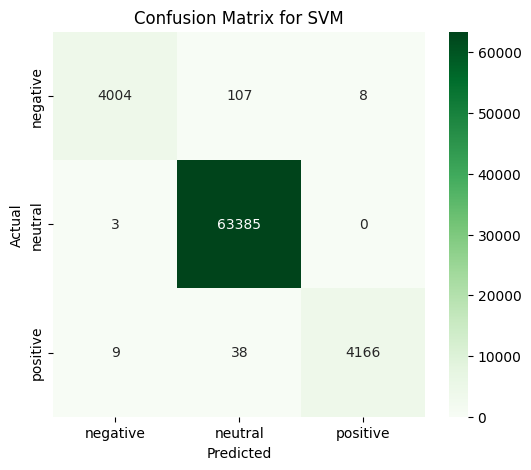

In [53]:
# Display confusion matrix of SVM
cnmx_svm = confusion_matrix(y_test, y_pred_svm, labels=labels)
plt.figure(figsize=(6, 5))
sns.heatmap(cnmx_svm, annot=True, fmt='d', cmap='Greens',xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix for SVM')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [54]:
# performs Grid Search on Linear SVM model
param_grid_svm = {'C': [0.01, 0.1, 1, 10]}
base_svm = LinearSVC(random_state=42, max_iter=2000)
grid_svm = GridSearchCV(base_svm, param_grid_svm, cv=3, scoring='accuracy', n_jobs=-1)
grid_svm.fit(X_train_vec, y_train)
best_svm = grid_svm.best_estimator_
calibrated_svm = CalibratedClassifierCV(best_svm)
calibrated_svm.fit(X_train_vec, y_train)
print('The best params in SVM are: ')
print(grid_svm.best_params_)
print(f"The Best Accuracy obtained: {grid_svm.best_score_:.4f}")

The best params in SVM are: 
{'C': 1}
The Best Accuracy obtained: 0.9977


#### Comparison of Different classical Models
| Model Title           | Accuracy | F1-score (weighted) | Log Loss |
|-----------------------|----------|---------------------|----------|
| Logistic Regression   | 0.9959   | 0.9959              | 0.0282   |
| Random Forest         | 0.9977   | 0.9977              | 0.0685   |
| Linear SVM            | 0.9977   | 0.9977              | 0.0190   | 


#### The above data shows the experiment that I did to find the best classical model. From the values obtained, It is visible that all three models perform well on sentiment classification task, achieving good accuracy and F1-scores. However,Linear SVM becomes the best model by achieveling lower log less score of 0.0190 compared to the other two, claiming it is more reliable. Even though Logistic regression is strong, its log loss results are higher than SVM, stating that its performance is not accurate in minority class. Therefore, proceeding with SVM Model for further analysis.

# Combining Deep learning Model: BERT

In [57]:
#Reduces the dataset for BERT, taking only 100 samples as it takes a lot longer than expected to run
df_bert = df.sample(n=1000, random_state=42).reset_index(drop=True)

# Encoding target labels for BERT only
le = LabelEncoder()
df_bert['label'] = le.fit_transform(df_bert['Sentiment'])

# Splits the data
train_texts, val_texts, train_labels, val_labels = train_test_split(df_bert['text'], df_bert['label'], test_size=0.2, random_state=42,
                                       stratify=df_bert['label'])

class_names = np.unique(train_labels)
class_weights = compute_class_weight(class_weight='balanced', classes=class_names, y=train_labels)   # class weight is added to balance the class
class_weights = torch.tensor(class_weights, dtype=torch.float)

# Tokenizes using BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Customise the Dataset
class EmotionDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=64):
        self.texts = list(texts)
        self.labels = list(labels)
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

# 6. print DataLoaders
train_dataset = EmotionDataset(train_texts, train_labels, tokenizer)
val_dataset = EmotionDataset(val_texts, val_labels, tokenizer)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

# 7. Device is set up
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#### The dataset is encoded and tokenized for BERT training and evaluation, along with the presence of class weights to address class imbalance.

In [58]:
#loads the BERT model using the reduced dataset
num_labels = len(le.classes_)
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_labels)
model = model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#### The above warning message is due to loading pre-trained BERT model for classification, and it will not affect model training and results

## BERT Training

In [59]:
opticlass_weights = class_weights.to(device) 
loss_fn = nn.CrossEntropyLoss(weight=class_weights)
optimizer = AdamW(model.parameters(), lr=2e-5)   # optimizer AdamW is defined
    
epochs = 3  # using 3 epochs as BERT is usually fine-tuned in between 2 to 5

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = loss_fn(outputs.logits, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
print(f"Epoch {epoch+1}, Total batch loss obtained: {total_loss/len(train_loader):.4f}")

Epoch 3, Total batch loss obtained: 0.3808


#### 

#### BERT's fine-tuning takes place on the data and reports the average batch loss obtained.

# BERT Model Evaluation

In [60]:
model.eval()
all_preds = []
all_labels = []
val_loss = 0
num_batches = 0

with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        logits = outputs.logits
        loss = outputs.loss
        preds = torch.argmax(logits, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        val_loss += loss.item()
        num_batches += 1

avg_val_loss = val_loss / num_batches if num_batches > 0 else 0

print("Classification Report:\n", classification_report(all_labels, all_preds))
print("Accuracy Score:", accuracy_score(all_labels, all_preds))
print("F1-score (weighted):", f1_score(all_labels, all_preds, average='weighted'))
print(f"Average Validation Loss: {avg_val_loss:.4f}")

Classification Report:
               precision    recall  f1-score   support

           0       0.41      0.58      0.48        12
           1       0.96      0.90      0.93       177
           2       0.56      0.82      0.67        11

    accuracy                           0.88       200
   macro avg       0.64      0.77      0.69       200
weighted avg       0.90      0.88      0.89       200

Accuracy Score: 0.88
F1-score (weighted): 0.8888879978615344
Average Validation Loss: 0.3118


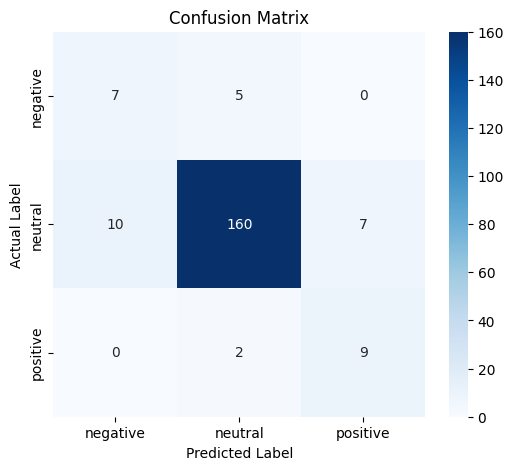

In [61]:
# confusion matrix of BERT model
cnmx = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cnmx, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Confusion Matrix')
plt.show()

# Model Comparison

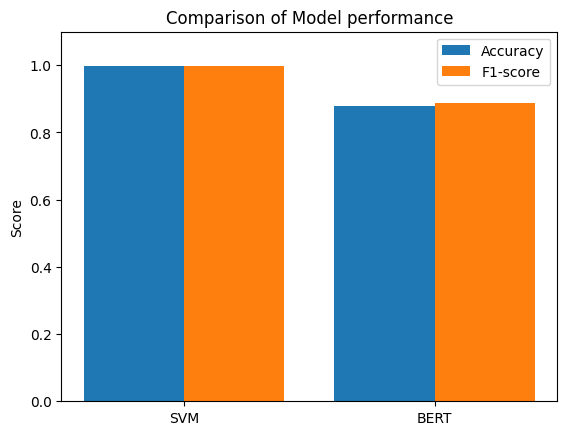

In [62]:
# visualising the models SVM and BERT to compare
models = ['SVM', 'BERT']
accuracy = [0.9977, 0.8800]
f1 = [0.9977, 0.8888]

x = range(len(models))
plt.bar(x, accuracy, width=0.4, label='Accuracy', align='center')
plt.bar([i + 0.4 for i in x], f1, width=0.4, label='F1-score', align='center')
plt.xticks([i + 0.2 for i in x], models)
plt.ylim(0, 1.1)
plt.ylabel('Score')
plt.title('Comparison of Model performance')
plt.legend()
plt.show()

### Comparison Table of each models

| Model | Accuracy | F1-score (weighted) | Log Loss / Last Batch Loss |
|-------|----------|---------------------|---------------------------|
| SVM   | 0.9977   | 0.9977              | 0.0190 (log loss)         |
| BERT  | 0.88     | 0.8888              | 0.3118 (batch loss)       |

#### From the above comparison table, it is visible that the SVM Model outperforms the BERT model with a highest accuracy of 0.9977 and F1-score of 0.9977. On the other hand, BERT is also able to score an above-average accuracy and F1-score; However, it also reached a higher batch loss of 0.3118. It indicates that the model SVM with TF-IDF feature extraction is the best for this business problem.

# Business Implications
#### * The developed NLP pipeline significantly decreases the manual effort and costs by enabling companies to process and classify large text data automatically.
#### * Classifying texts correctly and identifying issues makes it easier to look into decision-making quickly.
#### * The solution is able to handle a large amount of new data, which allows the organisations to grow and adapt without any extra cost investment.
#### * Considering the results of both models, SVM is better to use in the Business Deployment because of its higher efficiency and performance. BERT can be considered only if the new data requires an understanding of a deeper language.

## Strengths of the Model
#### * The pipeline is well structured, which supports both the SVM and BERT approaches.
#### * The pipeline is versatile, making it easier to use in other text classification tasks with slight changes.
#### * The comparative evaluation (implementing and comparing both SVM and BERT) helps to choose the best and accurate model for the business task based on real data.

## Limitations of the Model
#### * Due to the class imbalance in the dataset, BERT's recall for minority classes was lower in the classification report; this may lead the model to underperform on marginalized categories.
#### * BERT model is trained using only 100 samples as it needs significant computational resources.
#### * Deep learning models such as BERT are not well interpretable, which makes the reasons behind predictions harder to explain compared to classical models.
#### * In this business task, SVM is very efficient. However, the model may struggle to perform well on more complex text data.

## Implications of Business Problem
#### The developed NLP pipeline allows the business to understand the customer preferences and respond quickly. However, the high performance on the dataset may not always provide the same results in the real world, mainly if the data's nature changes. 

## Data Driven Recommendations
#### * Add more data to minority classes to make the dataset balanced.
#### * Consider BERT only if the dataset involves more complex textual data.
#### * Continuously assess the performance of the model when new data are added. So that the model will not degrade.
#### * If the future data is not so complex, always prefer SVM for business deployment(because of its high performance).

## Model Explainability
#### SVM is transparent and easier to explain. On the other hand, BERT is more complex and difficult to describe certain predictions. Therefore, use LIME or SHAP (post-hoc explainability tools) to explain such predictions.

# References
##### 1. Das, R. and Singh, T.D. (2023). Multimodal Sentiment Analysis: A Survey of Methods, Trends and Challenges. ACM Computing Surveys. doi:https://doi.org/10.1145/3586075.
##### 2. Nnadi, G. O., & Bertini, F. (2024). Survey on Abstractive Text Summarization: Dataset, Models, and Metrics. arXiv preprint arXiv:2412.17165.
##### 3. Jalilifard, A., Caridá, V.F., Mansano, A.F., Cristo, R.S. and da Fonseca, F.P.C. (2021). Semantic Sensitive TF-IDF to Determine Word Relevance in Documents. Lecture Notes in Electrical Engineering, pp.327–337. doi:https://doi.org/10.1007/978-981-33-6987-0_27.
##### 4. https://www.kaggle.com/code/khura55/emotion-analysis-with-svm
